In [1]:
! pip3 install onnx

     |████████████████████████████████| 12.7 MB 43 kB/s             


In [2]:
! pip3 install onnxruntime

     |████████████████████████████████| 5.6 MB 1.7 MB/s            
     |████████████████████████████████| 13.4 MB 12.8 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


In [3]:
! pip3 install opencv-contrib-python 

     |████████████████████████████████| 44.8 MB 40 kB/s              


In [4]:
! pip3 install azure-cognitiveservices-vision-customvision

     |████████████████████████████████| 62 kB 169 kB/s            
     |████████████████████████████████| 85 kB 506 kB/s            
     |████████████████████████████████| 63 kB 491 kB/s            
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
     |████████████████████████████████| 41 kB 350 kB/s             
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.7-py2.py3-none-any.whl (138 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)


In [5]:
import os
import sys
import onnxruntime
import onnx
import numpy as np
from PIL import Image, ImageDraw
from object_detection import ObjectDetection
import tempfile

import cv2
import matplotlib.pyplot as plt

In [6]:
ModelFile ='model.onnx'
ImageFile= 'demo.jpg'

In [7]:
with open('labels.txt', 'r') as f:
        labels = [l.strip() for l in f.readlines()]

In [8]:
print(labels)

['mask']


In [9]:
class ONNXRuntimeObjectDetection(ObjectDetection):
    """Object Detection class for ONNX Runtime"""
    def __init__(self, model_filename, labels):
        super(ONNXRuntimeObjectDetection, self).__init__(labels)
        model = onnx.load(model_filename)
        with tempfile.TemporaryDirectory() as dirpath:
            temp = os.path.join(dirpath, os.path.basename(ModelFile))
            model.graph.input[0].type.tensor_type.shape.dim[-1].dim_param = 'dim1'
            model.graph.input[0].type.tensor_type.shape.dim[-2].dim_param = 'dim2'
            onnx.save(model, temp)
            self.session = onnxruntime.InferenceSession(temp)
        self.input_name = self.session.get_inputs()[0].name
        self.is_fp16 = self.session.get_inputs()[0].type == 'tensor(float16)'
        
    def predict(self, preprocessed_image):
        inputs = np.array(preprocessed_image, dtype=np.float32)[np.newaxis,:,:,(2,1,0)] # RGB -> BGR
        inputs = np.ascontiguousarray(np.rollaxis(inputs, 3, 1))

        if self.is_fp16:
            inputs = inputs.astype(np.float16)

        outputs = self.session.run(None, {self.input_name: inputs})
        return np.squeeze(outputs).transpose((1,2,0)).astype(np.float32)

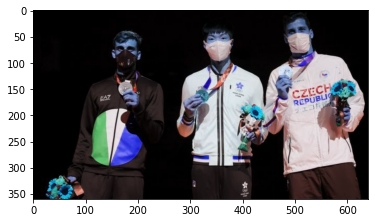

In [10]:
imcv = cv2.imread(ImageFile)
showImage = plt.imshow(imcv)

In [11]:
od_model = ONNXRuntimeObjectDetection(ModelFile, labels)
image = Image.open(ImageFile)
predictions = od_model.predict_image(image)

2022-01-07 10:11:36.190068716 [W:onnxruntime:, execution_frame.cc:811 VerifyOutputSizes] Expected shape from model of {None,30,13,13} does not match actual shape of {1,30,12,22} for output model_outputs0


In [12]:
print(predictions)

[{'probability': 0.89080215, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.51747437, 'top': 0.1718531, 'width': 0.06846677, 'height': 0.09850081}}, {'probability': 0.88496596, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.75070058, 'top': 0.12796867, 'width': 0.07732372, 'height': 0.11114827}}, {'probability': 0.50734061, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.24123404, 'top': 0.2423871, 'width': 0.08195085, 'height': 0.10856735}}, {'probability': 0.12998019, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.24898288, 'top': 0.29867881, 'width': 0.07406581, 'height': 0.123042}}, {'probability': 0.10253208, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.70142447, 'top': 0.36449472, 'width': 0.28229951, 'height': 0.35347143}}]


In [13]:
height, width, channels = imcv.shape
print(height)
print(width)

360
640


In [14]:
length = len(predictions) 
for i in range(length): 
    left1 = predictions[i]['boundingBox']['left']
    top1 = predictions[i]['boundingBox']['top']
    width1 = predictions[i]['boundingBox']['width']
    height1 = predictions[i]['boundingBox']['height']
    pre = predictions[i]['probability']
    if(pre > 0.5 ):
        left= (int)(left1 * width)
        top = (int)(top1 * height)
        w = (int)(width1 * width + left)
        h = (int)(height1 * height + top)
        cv2.rectangle(imcv,(left,top ),(w,h),(100,0,0),3 )

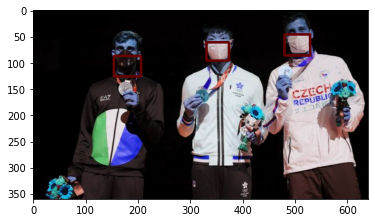

In [15]:
imgplot = plt.imshow(imcv)